In [1]:
import torch
import pickle
import numpy as np
import sys
sys.path.append('./../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import HTML
from matplotlib import style
#rc('animation', html='html5')

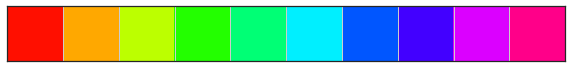

In [3]:
import seaborn as sns
sns.set()
sns.set_style('white')
#sns.set_style('whitegrid')
import matplotlib
plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')
#plt.rc('font', weight='bold')

#current_palette = sns.color_palette(sns.hls_palette(10+1, l=.5, s=1.0))
#current_palette = sns.color_palette(sns.hls_palette(21+1, l=.5, s=1.0))
current_palette = sns.color_palette(sns.hls_palette(10, l=.5, s=1.0))


#current_palette = sns.palplot(sns.hls_palette("bright", l=.5, s=1.0))
#current_palette = np.asarray(sns.color_palette("deep"))
#current_palette[0] 
base_c = [0.00784314, 0.24313725, 1. ]

sns.palplot(current_palette)


In [4]:
from utility.dataset import _process_Synthetic
from models_utility.construct_models import _combine_models
from utility.eval_metric import _measure_metric, accuracy, compute_bic
#torch.set_default_tensor_type(torch.FloatTensor)




file_path = './dataset/synthetic/'
file_name = 'Q6_Fs1000'
data_file_path = file_path + file_name


##############################################################################
# load dataset
##############################################################################
random_seed = 1000
num_exp = 2


###############################################
###############################################

exp_setting = {}
exp_setting['device'] = False

exp_setting['num_rep_exp'] = num_exp
exp_setting['data'] = file_name
exp_setting['full_length'] = 100

exp_setting['input_dim'] = 1
exp_setting['Num_HiddenState'] = 8
exp_setting['Num_Q'] = 6



x_train, y_train, z_train, x_test, y_test, z_test, true_freq, true_weight, true_noise_level, true_num_state = _process_Synthetic(data_file_path, exp_setting)
exp_setting['input_length'] = x_train.shape[1]


In [5]:
print('#' * 100)
print('(#sequences, #time-series observations)')
print('xtrain.shape {}, ytrain.shape {}, xtest.shape {}, ytest.shape {}'.format(x_train.shape,y_train.shape,x_test.shape,y_test.shape))

####################################################################################################
(#sequences, #time-series observations)
xtrain.shape (100, 1000), ytrain.shape (100, 1000), xtest.shape (50, 1000), ytest.shape (50, 1000)


In [6]:
###############################################################################################
# Model Setting
###############################################################################################


HMMGP_setting = {}
HMMGP_setting['emission'] = 'gprrff_beta' #
HMMGP_setting['Num_Q'] = exp_setting['Num_Q']


#HMMGP_setting['train'] = 'VBEM' #
HMMGP_setting['train'] = 'SVI' #
HMMGP_setting['lr_A'] = 0.05
HMMGP_setting['lr_pi'] = 0.05
HMMGP_setting['lr_hyp'] = 0.005 #for beta


HMMGP_setting['Len_Full'] = exp_setting['full_length']
if HMMGP_setting['train'] == 'VBEM':
    HMMGP_setting['Len_Batch'] = HMMGP_setting['Len_Full']
    HMMGP_setting['Num_Batch'] = 1
else:
    HMMGP_setting['Len_Batch'] = 10
    HMMGP_setting['Num_Batch'] = 1


HMMGP_setting['Iter_train'] = 50 #for beta
HMMGP_setting['Iter_hyp'] = 10 #for beta


HMMGP_setting['Rate_RRFFSpectralPt'] = 0.1
HMMGP_setting['Num_RRFFSpectralPt_total'] = int((exp_setting['input_length'] * HMMGP_setting['Rate_RRFFSpectralPt']))
HMMGP_setting['Num_RRFFBatch'] = 1
HMMGP_setting['Num_K_Emission'] = 3



HMMGP_setting['device'] = exp_setting['device']


# print('input_length : %d'%(exp_setting['input_length']))
# print('Num_RRFFSpectralPt : %d'%(int ( (exp_setting['input_length']*HMMGP_setting['Rate_RRFFSpectralPt']) )))
# print('train : %s, emission : %s, num Q : %d, total spt: %d, rate : %.2f'
#       %(HMMGP_setting['train'],HMMGP_setting['emission'],HMMGP_setting['Num_Q'],HMMGP_setting['Num_RRFFSpectralPt_total'],HMMGP_setting['Rate_RRFFSpectralPt']))



In [7]:
print('model: hmmgpsm(Q={}), infer: {}+{}, #full-sequences:{}, #sub-sequences: {}, #totalspt: {} #sptPerQ: {}'.format(HMMGP_setting['Num_Q'],
                                                                                                    HMMGP_setting['train'],
                                                                                                    HMMGP_setting['emission'],
                                                                                                    HMMGP_setting['Len_Full'],
                                                                                                    HMMGP_setting['Len_Batch'],
                                                                                                    int((exp_setting['input_length'] * HMMGP_setting['Rate_RRFFSpectralPt'])),
                                                                                                    int((exp_setting['input_length'] * HMMGP_setting['Rate_RRFFSpectralPt'])/HMMGP_setting['Num_Q']) ))


num_emission_param = exp_setting['Num_HiddenState']*(exp_setting['Num_Q']*(3*exp_setting['input_dim']) + 1 )
num_trasition_param = exp_setting['Num_HiddenState']**2 + exp_setting['Num_HiddenState']
num_modelparam = num_emission_param + num_trasition_param 
print('#model param : {}'.format(num_modelparam))

print('')

model: hmmgpsm(Q=6), infer: SVI+gprrff_beta, #full-sequences:100, #sub-sequences: 10, #totalspt: 100 #sptPerQ: 16
#model param : 224



## build the model and intialize the hyperparameters

In [8]:
model = _combine_models(x_train, y_train, exp_setting, HMMGP_setting,random_seed=random_seed,num_init_iter = 501)    

initialization_beta_rrff
initialization_beta_rrff
initialization_beta_rrff
initialization_beta_rrff
initialization_beta_rrff
initialization_beta_rrff
initialization_beta_rrff
initialization_beta_rrff
8
0 emission, 0 iter, loss 37589.8373 
0 emission, 50 iter, loss 22031.7082 
0 emission, 100 iter, loss 10684.8433 
0 emission, 150 iter, loss 8005.5061 
0 emission, 200 iter, loss 5869.0856 
0 emission, 250 iter, loss 4323.9399 
0 emission, 300 iter, loss 3203.3582 
0 emission, 350 iter, loss 2405.9461 
0 emission, 400 iter, loss 1792.5663 
0 emission, 450 iter, loss 1355.8054 
0 emission, 500 iter, loss 896.1375 

6
1 emission, 0 iter, loss 59836.7055 
1 emission, 50 iter, loss 9507.3432 
1 emission, 100 iter, loss 4190.9851 
1 emission, 150 iter, loss 3448.1396 
1 emission, 200 iter, loss 2573.0983 
1 emission, 250 iter, loss 1858.1775 
1 emission, 300 iter, loss 1308.0563 
1 emission, 350 iter, loss 794.6583 
1 emission, 400 iter, loss 568.3470 
1 emission, 450 iter, loss 380.3115 
1 e

## train the model

In [9]:
# for i_th in range(exp_setting['num_rep_exp']):    
#     model = _combine_models(x_train, y_train, exp_setting, HMMGP_setting,random_seed=random_seed,num_init_iter = 251)
    
#     loglik_list, train_accuracy_list, test_accuracy_list, \
#     time_list, num_cluster_list, param_history_dict = model.train(x_train, y_train, z_train, x_test, y_test, z_test)


#     print('#' * 100)

#     tr_elbo, tr_lik, te_elbo, te_lik = loglik_list[:,0], loglik_list[:,1], loglik_list[:,2], loglik_list[:,3]
#     tr_bic = compute_bic(x_train,y_train,tr_lik[-1],num_modelparam)
#     te_bic = compute_bic(x_test,y_test,te_lik[-1],num_modelparam)



  
loglik_list, train_accuracy_list, test_accuracy_list, time_list, param_history_dict, z_pred_list  = model.train(x_train, y_train, z_train, x_test, y_test, z_test)


----------------------------------------------------------------------------------------------------
iter 1, iteration time : 2.411| train acc : 0.650, train lik : -13049622.204, 	 test acc : 0.560, test lik : -3772646.665 |e train acc : 0.740, e train lik : -943336.784 e test acc : 0.720, e test lik : -284290.803 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
iter 5, iteration time : 2.600| train acc : 0.700, train lik : -10958631.357, 	 test acc : 0.660, test lik : -3081531.448 |e train acc : 0.680, e train lik : -752525.418 e test acc : 0.620, e test lik : -207082.109 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
iter 10, iteration time : 2.476| train acc : 0.680, train lik :

NameError: name 'compute_bic' is not defined

In [56]:
train_accuracy_list, test_accuracy_list

(array([[0.65, 0.74],
        [0.7 , 0.68],
        [0.68, 0.68],
        [0.71, 0.69],
        [0.72, 0.71],
        [0.7 , 0.73],
        [0.73, 0.78],
        [0.78, 0.84],
        [0.81, 0.82],
        [0.74, 0.8 ],
        [0.77, 0.84]]), array([[0.56, 0.72],
        [0.66, 0.62],
        [0.66, 0.64],
        [0.76, 0.68],
        [0.74, 0.72],
        [0.76, 0.78],
        [0.76, 0.78],
        [0.8 , 0.86],
        [0.84, 0.88],
        [0.8 , 0.84],
        [0.84, 0.8 ]]))

## metric

In [55]:
tr_elbo, tr_lik, te_elbo, te_lik = loglik_list[:,0], loglik_list[:,1], loglik_list[:,2], loglik_list[:,3]
tr_bic = compute_bic(x_train,y_train,tr_lik[-1],num_modelparam)
te_bic = compute_bic(x_test,y_test,te_lik[-1],num_modelparam)
z_train_pred,z_test_pred = z_pred_list[-1]
revised_order_dict, revised_z_test_pred, _ = _measure_metric(z_test, z_test_pred)

In [16]:
figsiz2 = (20,2) 
labelsiz = 15
fontsiz = 20
interval = 0.2
xlimit_range = [110,140]

In [20]:
#z_test_pred = result_pickle['test_pred'][chosen_idx]
revised_order_dict, revised_z_test_pred, _ = _measure_metric(z_test, z_test_pred)
revised_z_test_pred = revised_z_test_pred

## test set

No handles with labels found to put in legend.


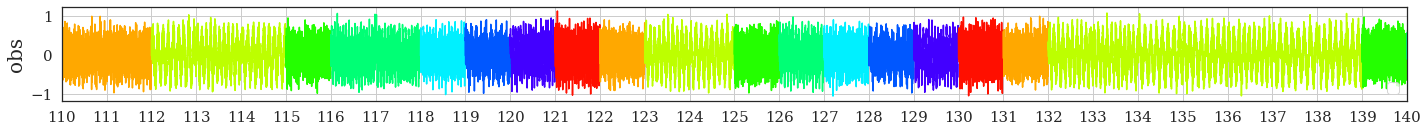

In [21]:

fig = plt.figure(figsize = figsiz2 )
for ith,(ith_x,ith_y,ith_z) in enumerate(zip(x_test,y_test,z_test)):
    plt.plot(ith_x , ith_y , color = current_palette[ith_z])

plt.tick_params(labelsize=labelsiz) 
plt.xlim(xlimit_range)

plt.ylabel('obs',fontsize = fontsiz)
#plt.xlabel('time',fontsize = fontsiz)

plt.yticks(fontsize = 15)
plt.xticks(np.arange(xlimit_range[0],xlimit_range[1]+1),fontsize = 15 )

#plt.xlabel('log10 training time (sec)',fontsize = fontsiz)
plt.legend(loc='lower right',fontsize = 15)
fig.tight_layout()    

plt.show()



## estimation for test set

In [22]:
fig = plt.figure(figsize = figsiz2 )
for ith,(ith_x,ith_y,ith_z) in enumerate( zip(x_test,y_test,revised_z_test_pred)):
    plt.plot(ith_x , ith_y , color = current_palette[ith_z])

#    plt.plot( ith_x, ith_y , color = current_palette[ith_z])

plt.tick_params(labelsize=labelsiz) 
plt.xlim(xlimit_range)

plt.ylabel('obs',fontsize = fontsiz)
# plt.xlabel('time',fontsize = fontsiz)
plt.xticks(np.arange(xlimit_range[0],xlimit_range[1]+1),fontsize = 15 )
plt.yticks(fontsize = 15)

#plt.xlabel('log10 training time (sec)',fontsize = fontsiz)
plt.legend(loc='lower right',fontsize = 15)
fig.tight_layout()    

#plt.savefig(save_figure_path + model_name + '_pred'  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()


No handles with labels found to put in legend.


## accuracy 
Here, the HMMGPSM is trained by SVI+AGPE. 
When estimating the hidden states of the sequences observations, both the exact GP emission and the approximate GP emission can be used; the exact GP emission is used with the parameters obtained by SVI+AGPE. Since the computation for the exact GP emission is conducted once for the evaluation on test set, SVI+AGPE can reduce much training time.

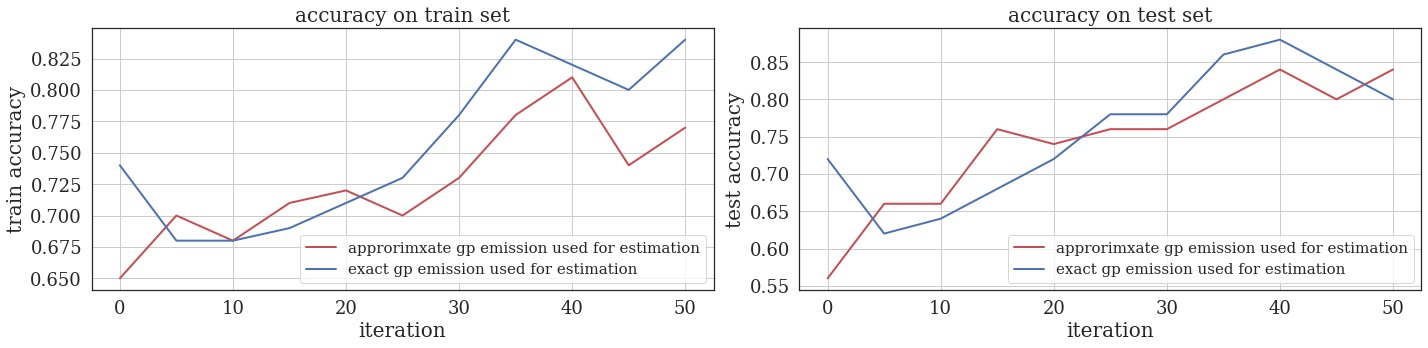

In [58]:
iters = np.arange(HMMGP_setting['Iter_train']+1)[::5]

figsiz = (20,5) 
#figsiz = (6,4) 
labelsiz = 15
fontsiz = 15
interval = 0.2

fig = plt.figure(figsize = figsiz)
# plt.plot(time_list.cumsum(),train_accuracy_list)
# plt.xlabel('time (sec)',fontsize = 20)

plt.subplot(1,2,1)
plt.plot(iters,train_accuracy_list[:,0],'r',label='approrimxate gp emission used for estimation',linewidth=2)
plt.plot(iters,train_accuracy_list[:,1],'b',label='exact gp emission used for estimation',linewidth=2)
plt.xlabel('iteration',fontsize = 20)


#plt.xscale('log',basex=10) 
plt.ylabel('train accuracy',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.title('accuracy on train set',fontsize=20)


plt.subplot(1,2,2)
plt.plot(iters,test_accuracy_list[:,0],'r',label='approrimxate gp emission used for estimation',linewidth=2)
plt.plot(iters,test_accuracy_list[:,1],'b',label='exact gp emission used for estimation',linewidth=2)
plt.xlabel('iteration',fontsize = 20)

plt.ylabel('test accuracy',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.title('accuracy on test set',fontsize=20)



fig.tight_layout()    
plt.show()
